<a href="https://colab.research.google.com/github/ManuSanchez02/7506R-2c2022-GRUPO09/blob/main/tp2/7506_R_TP2_GRUPO09_ENTREGA_N3(Ensambles).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Bibliotecas necesarias

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import KFold
from joblib import dump, load 

from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline 
from sklearn.metrics import r2_score
from sklearn import metrics

np.random.seed(1)

## Modelos

In [ ]:
!wget https://github.com/ManuSanchez02/7506R-2c2022-GRUPO09/raw/main/tp2/arbolDeDecision.joblib -O arbol_de_decision.joblib
!wget https://github.com/ManuSanchez02/7506R-2c2022-GRUPO09/raw/main/tp2/randomForest.joblib -O random_forest.joblib
!wget https://github.com/ManuSanchez02/7506R-2c2022-GRUPO09/raw/main/tp2/regresionLogistica.joblib -O regresion_logistica.joblib
!wget https://github.com/ManuSanchez02/7506R-2c2022-GRUPO09/raw/main/tp2/regresionLinealComparador.joblib -O regresion_lineal.joblib
!wget https://github.com/ManuSanchez02/7506R-2c2022-GRUPO09/raw/main/tp2/knn.joblib -O knn.joblib
!wget https://github.com/ManuSanchez02/7506R-2c2022-GRUPO09/raw/main/tp2/xgb.joblib -O xgb.joblib
!wget https://github.com/ManuSanchez02/7506R-2c2022-GRUPO09/raw/main/tp2/gradientBoosting.joblib -O gradient_boosting.joblib

--2022-11-18 16:28:21--  https://github.com/ManuSanchez02/7506R-2c2022-GRUPO09/raw/main/tp2/arbolDeDecision.joblib
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ManuSanchez02/7506R-2c2022-GRUPO09/main/tp2/arbolDeDecision.joblib [following]
--2022-11-18 16:28:22--  https://raw.githubusercontent.com/ManuSanchez02/7506R-2c2022-GRUPO09/main/tp2/arbolDeDecision.joblib
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 908544 (887K) [application/octet-stream]
Saving to: ‘arbol_de_decision.joblib’

arbol_de_decision.j 100%[===================>] 887.25K  --.-KB/s    in 0.06s   

2022-11-18 16:28:22 (14

In [ ]:
# Modelos clasificación
arbol_de_decision = load("arbol_de_decision.joblib")
random_forest = load("random_forest.joblib")
regresion_logistica = load("regresion_logistica.joblib")

# Modelos regresión
regresion_lineal = load("regresion_lineal.joblib")
knn = load("knn.joblib")
xgboost = load("xgb.joblib")
gradient_boost = load("gradient_boosting.joblib")

[16:28:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


## Datasets

In [ ]:
clasificacion_train_feature = pd.read_csv("https://github.com/ManuSanchez02/7506R-2c2022-GRUPO09/blob/main/tp2/datasets/clasificacion_train_feature.csv?raw=true")
clasificacion_train_target = pd.read_csv("https://github.com/ManuSanchez02/7506R-2c2022-GRUPO09/blob/main/tp2/datasets/clasificacion_train_target.csv?raw=true")
clasificacion_test_feature = pd.read_csv("https://github.com/ManuSanchez02/7506R-2c2022-GRUPO09/blob/main/tp2/datasets/clasificacion_test_feature.csv?raw=true")
clasificacion_test_target = pd.read_csv("https://github.com/ManuSanchez02/7506R-2c2022-GRUPO09/blob/main/tp2/datasets/clasificacion_test_target.csv?raw=true")
regresion_train_feature = pd.read_csv("https://github.com/ManuSanchez02/7506R-2c2022-GRUPO09/blob/main/tp2/datasets/regresion_train_feature.csv?raw=true")
regresion_train_target = pd.read_csv("https://github.com/ManuSanchez02/7506R-2c2022-GRUPO09/blob/main/tp2/datasets/regresion_train_target.csv?raw=true")
regresion_test_feature = pd.read_csv("https://github.com/ManuSanchez02/7506R-2c2022-GRUPO09/blob/main/tp2/datasets/regresion_test_feature.csv?raw=true")
regresion_test_target = pd.read_csv("https://github.com/ManuSanchez02/7506R-2c2022-GRUPO09/blob/main/tp2/datasets/regresion_test_target.csv?raw=true")

clasificacion_train_feature.drop(["Unnamed: 0", "id"], axis = 1, inplace=True)
clasificacion_train_target.drop(["Unnamed: 0"], axis = 1, inplace=True)
clasificacion_test_feature.drop(["Unnamed: 0", "id"], axis = 1, inplace=True)
clasificacion_test_target.drop(["Unnamed: 0"], axis = 1, inplace=True)
regresion_train_feature.drop(["Unnamed: 0", "id"], axis = 1, inplace=True)
regresion_train_target.drop(["Unnamed: 0"], axis = 1, inplace=True)
regresion_test_feature.drop(["Unnamed: 0", "id"], axis = 1, inplace=True)
regresion_test_target.drop(["Unnamed: 0"], axis = 1, inplace=True)


# Voting

Convertimos las categorías del target de clasificacion en categorías numéricas

In [ ]:
label_encoder = preprocessing.LabelEncoder()
clasificacion_train_target = label_encoder.fit_transform(clasificacion_train_target)
clasificacion_test_target = label_encoder.transform(clasificacion_test_target)

Creamos ensamble de votación

In [ ]:
regresion_logistica_escalado = Pipeline([("ss", StandardScaler()), ("rl", regresion_logistica)])

In [ ]:
#vot_clf = VotingClassifier(estimators = [('add', arbol_de_decision), ('rf', random_forest), ('rl', regresion_logistica)], voting = 'soft') Score 0.66
#vot_clf = VotingClassifier(estimators = [('add', arbol_de_decision), ('rf', random_forest)], voting = 'soft') Score 0.64
#vot_clf = VotingClassifier(estimators = [('add', arbol_de_decision), ('rf', random_forest), ('rle', regresion_logistica_escalado)], voting = 'soft') #Score 0.65
vot_clf = VotingClassifier(estimators = [('add', arbol_de_decision), ('rf', random_forest), ('rle', regresion_logistica_escalado)], voting = 'hard') #Score 0.685

Entrenamos el modelo

In [ ]:
vot_clf.fit(clasificacion_train_feature, clasificacion_train_target)

Evaluamos en el conjunto de test

In [ ]:
clasificacion_pred_target = vot_clf.predict(clasificacion_test_feature)
print("El score es: ", accuracy_score(clasificacion_test_target, clasificacion_pred_target))

El score es:  0.6853053656275351


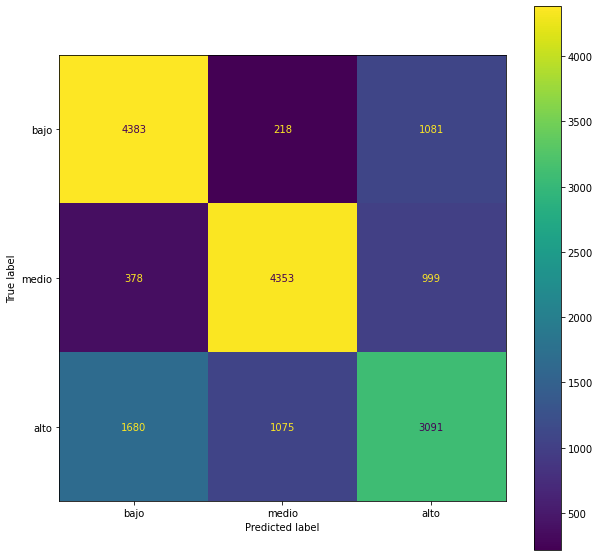

In [ ]:
labels=["bajo","medio","alto"]

fig, ax = plt.subplots(1,1,figsize=(10,10))
ConfusionMatrixDisplay.from_predictions(clasificacion_test_target, clasificacion_pred_target, display_labels=labels,ax=ax)

# Stacking

Creamos el modelo

In [ ]:
# Modelos Base
base_models = [('knn', knn),
               ('xgb', xgboost),
               ('gb', gradient_boost)]

# Creamos el ensamble
stacking_model = StackingRegressor(estimators=base_models, 
                                    final_estimator=regresion_lineal, 
                                    passthrough=True, 
                                    cv=5,
                                    verbose=2)

Entrenamos el modelo de stacking

In [ ]:
stacking_model.fit(regresion_train_feature, regresion_train_target)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_stacking.py:758: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[16:49:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Medimos la performance

In [ ]:
def imprimir_metricas_regresion(target_test, precios_predichos):
    # Mean Square Error
    mse = metrics.mean_squared_error(
        y_true=target_test, y_pred=precios_predichos, squared=True
    )

    print(f"El error (mse) de test es: {mse}")

    # Root Mean Square Error
    rmse = metrics.mean_squared_error(
        y_true=target_test, y_pred=precios_predichos, squared=False
    )

    print(f"El error (rmse) de test es: {rmse}")

    r2 = r2_score(target_test, precios_predichos)
    print(f"El score R2 es: {r2}")
  
regresion_pred_target = stacking_model.predict(regresion_test_feature)

imprimir_metricas_regresion(regresion_test_target, regresion_pred_target)


El error (mse) de test es: 2179735848.27748
El error (rmse) de test es: 46687.641279866344
El score R2 es: 0.7948085081456135
